# Домашнее задание №2 - Линейные модели. Градиентный спуск

В этом домашнем задании мы с вами научимся обучать линейные модели регрессии и классификации при помощи очень мощного, но в то же время довольно понятного алгоритма, который называется **градиетный спуск**. Помимо линейных моделей он используется и для обучения самых сложных нейронных сетей! Также мы потренируемся применять готовые реализации линейных моделей для задач регрессии и бинарной классификации.

In [420]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import pandas as pd
from scipy.optimize import approx_fprime

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.exceptions import NotFittedError
from sklearn.linear_model import (LinearRegression,
                                  LogisticRegression)
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import (StandardScaler, LabelEncoder, OneHotEncoder)                       
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.metrics import (r2_score,
                             mean_squared_error)
from sklearn.model_selection import train_test_split

In [421]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

#### Маленькое теоретическое отступление

Основное свойство антиградиента (-1 * градиент) &ndash; он указывает в сторону наискорейшего убывания функции в данной точке. Соответственно, будет логично стартовать из некоторой точки, сдвинуться в сторону антиградиента, пересчитать антиградиент и снова сдвинуться в его сторону и т.д. Запишем это более формально.

Пусть $w_0$ &ndash; начальный набор параметров (коэффициентов линейной модели) ((например, нулевой или сгенерированный из некоторого, случайного распределения)). Тогда обычный градиентный спуск состоит в повторении следующих шагов до сходимости:


$$
    w_{k + 1} = w_{k} - \eta \nabla_{w} Q(w_{k}),
$$

где $\nabla_{w} Q(w_{k})$ &ndash; градиент функции потерь в точке $w_k$, а $\eta$ &ndash; скорость обучения (learning rate).

Градиентный спуск обычно останавливают, когда прошло заданное максимальное количество итераций или когда графиент близок к нулю (т.е. наши параметры практически не меняются). Для реализации второго варианта считают норму градиента (по сути длину вектора). Это можно сделать несколькими способами:

$$
l1_{norm} = \sum{|w_i|}
$$

$$
l2_{norm} = \sum{(w_i)^{2}}
$$

Попробуем разобраться на простом примере. Рассмотрим функцию от двух переменных:
$f(x, y) = \sin^2 x + \sin^2 y$

In [422]:
def f(w):
    """
    :param w: np.array(np.float) вектор из 2-х элементов
    :return: np.float
    """
    
    return np.sum(np.sin(w)**2)

Обратите внимание, что $x$ - numpy-array вектор длины 2.

***Reminder:***  
Что мы хотим? Мы хотим найти минимум этой функции (в машинном обучении мы обычно хотим найти минимум **функции потерь**, например, MSE), а точнее найти $w_1$ и $w_2$ такие, что при них значение $f(w_1, w_2)$ минимально, то есть *точку экстремума*.  
  
Как мы будем искать эту точку? Используем методы оптимизации (в нашем случае - *минимизации*). Одним из таких методов и является **градиентный спуск**.

### Задание 1. Градиентный спуск для функции $f$ (1 балл)

Реализуйте функцию, которая будет осуществлять градиентный спуск для функции $f$:

*Примечание:* Вам нужно посчитать частные производные именно **аналитически** и **переписать их в код**, а не считать производные численно (через отношение приращения функции к приращению аргумента) -- в этих двух случаях могут различаться ответы, поэтому будьте внимательны.

In [423]:
def grad_f(w): 
    """
    Градиент функциии f, определенной выше.
        :param w: np.array[2]: float вектор из 2-х элементов
        :return: np.array[2]: float вектор из 2-х элементов
    """
    
    """
    YOUR CODE IS HERE
    """
    return approx_fprime(w, f, epsilon=1e-6)

Проверим, что градиент принимает вектор из двух чисел и выдает на этой точке верное значение

In [424]:
assert np.allclose(grad_f(np.array([1, 2])), 
                   np.array([0.90929743, -0.7568025])), "Что-то не так!"

In [425]:
def grad_descent_2d(f, grad_f, lr, num_iter=100, x0=None):
    """
    Функция, которая реализует градиентный спуск в минимум для функции f от двух переменных. 
        :param f: скалярная функция двух переменных
        :param grad_f: функция, возвращающая градиент функции f (устроена как реализованная вами выше grad_f)
        :param lr: learning rate алгоритма
        :param num_iter: количество итераций градиентного спуска
        :return: np.array[num_iter, 2] пар вида (x, f(x))
    """
    
    w0 = np.random.random(2)

    # будем сохранять значения аргументов и значений функции 
    # в процессе град. спуска в переменную history
    history = []

    # итерация цикла == шаг градиентнго спуска
    curr_w = w0.copy()
    for iter_num in range(num_iter):
        entry = np.hstack((curr_w, f(curr_w)))
        history.append(entry)
    
        curr_w -= lr * grad_f(curr_w)

    return np.vstack(history)

Визуализируем точки градиентного спуска на 3D-графике нашей функции. Звездочками будут обозначены точки (тройки $w_1, w_2, f(w_1, w_2)$), по которым Ваш алгоритм градиентного спуска двигался к минимуму (Для того, чтобы написовать этот график, мы и сохраняли значения $cur\_w_1, cur\_w_2, f(cur\_w_1, cur\_w_2)$ в `steps` в процессе спуска).

Если у Вас правильно написана функция `grad_descent_2d`, то звездочки на картинке должны сходиться к одной из точек минимума функции. Вы можете менять начальные приближения алгоритма, значения `lr` и `num_iter` и получать разные результаты.

In [426]:
def gradient_desc_vis(f, grad_f, lr=0.1, num_iter=20):
    steps = grad_descent_2d(f, grad_f, lr=lr, num_iter=num_iter)
    
    X, Y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))

    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(projection="3d")

    zs = np.array([f(np.array([x,y]))
                  for x, y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)


    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, zorder=2)

    ax.plot(xs=steps[:, 0], ys=steps[:, 1], zs=steps[:, 2],
            marker="*", markersize=20, zorder=3, 
            markerfacecolor="y", lw=3, c="black")

    ax.set_zlim(0, 5)
    ax.view_init(elev=60)
    plt.show()
    
    return steps

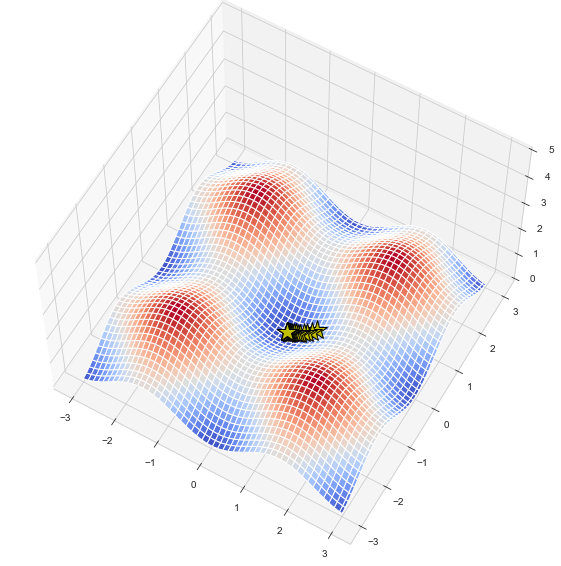

In [427]:
steps = gradient_desc_vis(f, grad_f)

Посмотрим на зависимость значения функции от шага градиентного спуска.

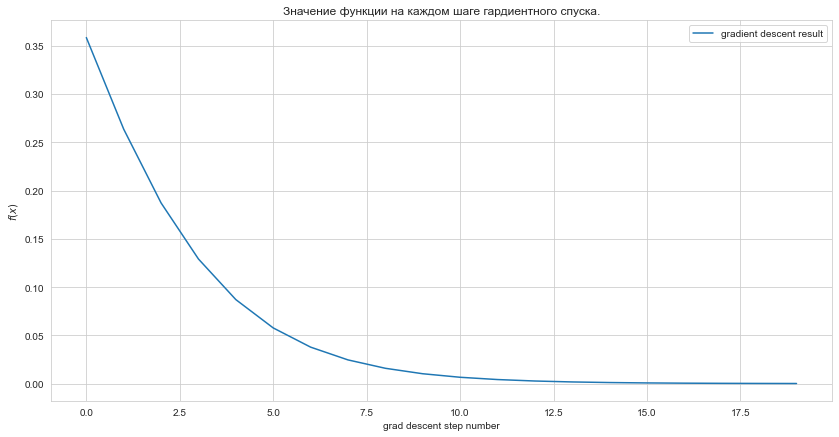

In [428]:
plt.figure(figsize=(14,7))
plt.xlabel("grad descent step number")
plt.ylabel("$f(x)$")
plt.title("Значение функции на каждом шаге гардиентного спуска.")

f_values = list(map(lambda x: x[2], steps))
plt.plot(f_values, label="gradient descent result")
plt.legend();

### Задание 2. Реализация линейной регресии (суммарно 9 баллов)

Так как мы будем использовать градиентный спуск для обучения модели, важной часть является реализация функции потерь и функции для расчета ее градиента. Перем началом стоит напомнить, как считать градиент MSE. Вывод этой формулы можно найти  [здесь](https://medium.com/analytics-vidhya/linear-regression-gradient-descent-intuition-and-math-c9a8f5aeeb22)

$$
    MSE = \frac{1}{N}\sum(y_{true} - y_{pred}) ^ 2
$$

$$
    \nabla{MSE} = \frac{2}{N} X^T (y_{pred} - y_{true})
$$

Здесь имеется в виду именно матричное умножение.

#### Задание 2.1. MSE и ее градиент (2 балла)

In [389]:
def mse(y_true, y_pred):
    """
    Функция потерь MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    return np.mean(np.sum((y_true - y_pred)**2))


def mse_grad(y_true, y_pred, X):
    """
    Функция для расчета градиента MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: градиент функции потерь MSE
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")

    return (2/y_true.shape[0]) * np.dot(X.T, y_pred - y_true)


class MSELoss:
    """
    Класс, реализующий функцию потерь MSE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return mse(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return mse_grad(y_true, y_pred, X)

Мы будем использовать следующий класс для расчета градиента наших функций потерь:

In [390]:
class BasicGradientDescent:
    """
    Класс, позволяющий делать шаги градиентного спуска,
    а также рассчитывающих норму градиента.
    """
    
    def __init__(self, loss_function, grad_norm):
        self.loss = loss_function
        self.grad_norm = grad_norm
        
    
    def step(self, y, y_pred, X):
        grad_i = self.loss.calculate_gradient(y, y_pred, X)
        grad_i_norm = self._calculate_grad_norm(grad_i)
        
        return grad_i, grad_i_norm
            
            
    def _calculate_grad_norm(self, grad_i):
        if self.grad_norm == "l1":
            return np.abs(grad_i).sum()
        elif self.grad_norm == "l2":
            return np.sqrt(np.square(grad_i).sum())
        else:
            raise ValueError(f"I can't calculate {self.grad_norm} norm of gradient")

В данном задании нужно будет реализовать линейную регрессию и обучить ее при помощи градиентного спуска. Для этого нужно будет заполнять пропуски кода в соответствующих классах. Для начала мы реализуем базовый класс для всех линейных моделей, от которого потом будем наследоваться при реализации линейной и логистической регресий. Не переживайте, этот класс уже реализован, вам достостаточно просто разобраться с кодом.

In [391]:
class BaseLinearModel:
    """
    Класс, который представляет из себя базовую линейную модель, наследуюясь от которого, мы будем
    реализовывать линейную и логистическую регрессии.
    """
    
    def __init__(self, learning_rate, 
                 loss_function, fit_intercept,
                 n_iter, tol, optimizer, grad_norm):
        """
        Конструктор нашего класса. 
            :param learning_rate: скорость обучения
            :param loss_function: функция потерь (MSE или кросс-энтропия)
            :param fit_intercept: нужно ли нам включать свободных член в модель
            :param n_iter: количество итераций градиентного спуска
            :param tol: параметр для остановки градиентного спуска,
                        если норма градиента (l1 или l2) меньше tol, то останавливаемся
            :param optimizer: класс, который будет рассчитывать градиент и его норму
            :param grad_norm: тип нормы градиента l1 или l2
        """
        
        self.learning_rate = learning_rate
        self.loss = loss_function
        self.fit_intercept = fit_intercept
        self.n_iter = n_iter
        self.tol = tol
        self.grad_norm = grad_norm
        self.optimizer = optimizer(loss_function, grad_norm)
        
        # В начале параметры модели не заданы
        self.W = None
        
        
    def fit(self, X, y):
        """
        Метод для обучения нашей модели 
            :param X: матрица объекты x признаки
            :param y: вектор значений целевой переменной
            :return: обученная модель
        """
        
        # Сделаем из y вектор-столбец (n_samples, 1)
        y = y.reshape(-1, 1)
        n_samples = X.shape[0]
        
        # Добавим колонку из 1 в матрицу X
        if self.fit_intercept:
            ones_column = np.ones((n_samples, 1))
            X_new = np.hstack((ones_column, X))
        
        n_features = X_new.shape[1]
        
        # Инициализируем веса модели
        if self.W is None:
            self.W = np.random.randn(n_features, 1)
        
        # Обучаем модель градиентным спуском
        for i in range(self.n_iter):
            y_pred = self.predict(X)
            grad_i, grad_i_norm = self.optimizer.step(y, y_pred, X_new)
            
            # Если градиент близок к 0, останавливаемся
            if grad_i_norm <= self.tol:
                return self
            
            else:
                self.W -= self.learning_rate * grad_i
        
        return self
    
    
    def predict(self, X):
        raise NotImplementedError("It is a basic class for all linear models. You should implement it for descendant class.")
    
    
    def __repr__(self):
        return "Base linear model without prediction skill :("

#### Задание 2.2. Предсказания линейной регрессии (3 балла)

Реализуйте метод `predict` у класса `CustomLinearRegression`, не забудьте про свободный член!

In [392]:
class CustomLinearRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-2, 
                 loss_function=MSELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        # Если вы не проходили наследование и в частности `super`, то не страшно
        # коротко, с помощью этого мы можем вызывать методы родительского класса
        # в частности здесь мы используем метод `init`
        super().__init__(learning_rate=learning_rate, 
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
        
    
    def predict(self, X_test):
        """
        Метод для вычисления предсказаний 
            :param X_test: np.array[n_test_samples, n_features]: 
                           матрица объекты x признаки (тестовый датасет)
            :return: y_pred: np.array[n_test_samples, 1]: предсказания модели
        """
        
        if self.W is None:
            raise NotFittedError("This CustomLinearRegression instance is not fitted yet, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))

            y_pred = np.matmul(X_test, self.W)  
            return y_pred          
    
    
    def __repr__(self):
        return "My custom linear regression"

##### Проверим нашу реализацию на простом примере

In [393]:
X = np.random.randn(100, 1)
y = 2 * X + 5 + 0.5 * np.random.randn(100, 1)

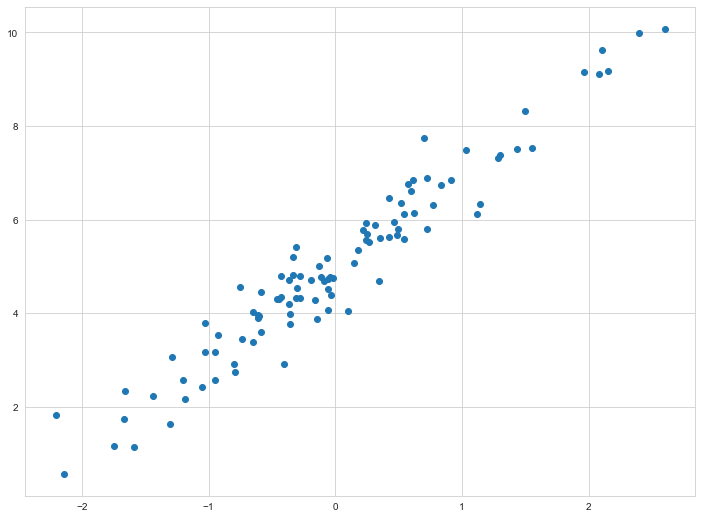

In [394]:
plt.scatter(X, y);

In [395]:
custom_lin_reg = CustomLinearRegression()

In [396]:
custom_lin_reg.fit(X, y)

My custom linear regression

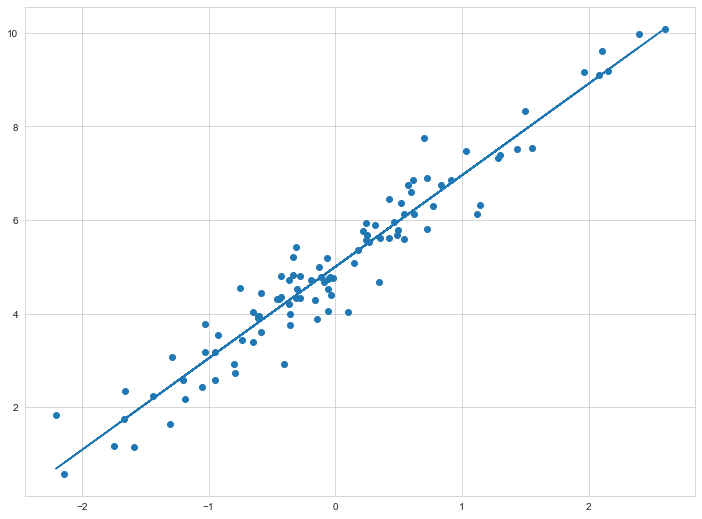

In [397]:
plt.scatter(X, y)
plt.plot(X, custom_lin_reg.predict(X));

#### Задание 2.3. Используем встроенную линейную регрессию (4 балла)

Поработаем с данными о ценах на дома в Калифорнии. Постройте модель линейной регресии при помощи `LinearRegression` из `sklearn`. Не забудьте разделить данные на тренировочную и тестовую части, а также правильно предобработать признаки. В конце воспользуйтесь какими-то изученными метриками регресии и сделайте выводы о качестве полученной модели, а также о том, какие признаки наиболее важны с точки зрения полученной модели.

In [398]:
data = fetch_california_housing(as_frame=True)
X, y = data["data"], data["target"]
feature_names = data["feature_names"]

Ваш ход:

Проведем небольшой EDA:

In [399]:
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [400]:
print(X.info())
print(f'\nNumber of variables: {X.shape[1]}')
print(f'Number of observations: {X.shape[0]}')
print(f'NA in dataset: {sum(X.isna().sum())}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB
None

Number of variables: 8
Number of observations: 20640
NA in dataset: 0


In [401]:
X.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


In [402]:
X.nunique()

MedInc        12928
HouseAge         52
AveRooms      19392
AveBedrms     14233
Population     3888
AveOccup      18841
Latitude        862
Longitude       844
dtype: int64

Проаналтзируем каждую из переменных и увидим, что 4 из них имеют существенные выбросы. Тогда поступим следующим образом: посчитаем метрики регрессии для модели с выбросами в переменных, посчитаем метрики модели без выбросов в переменных. 

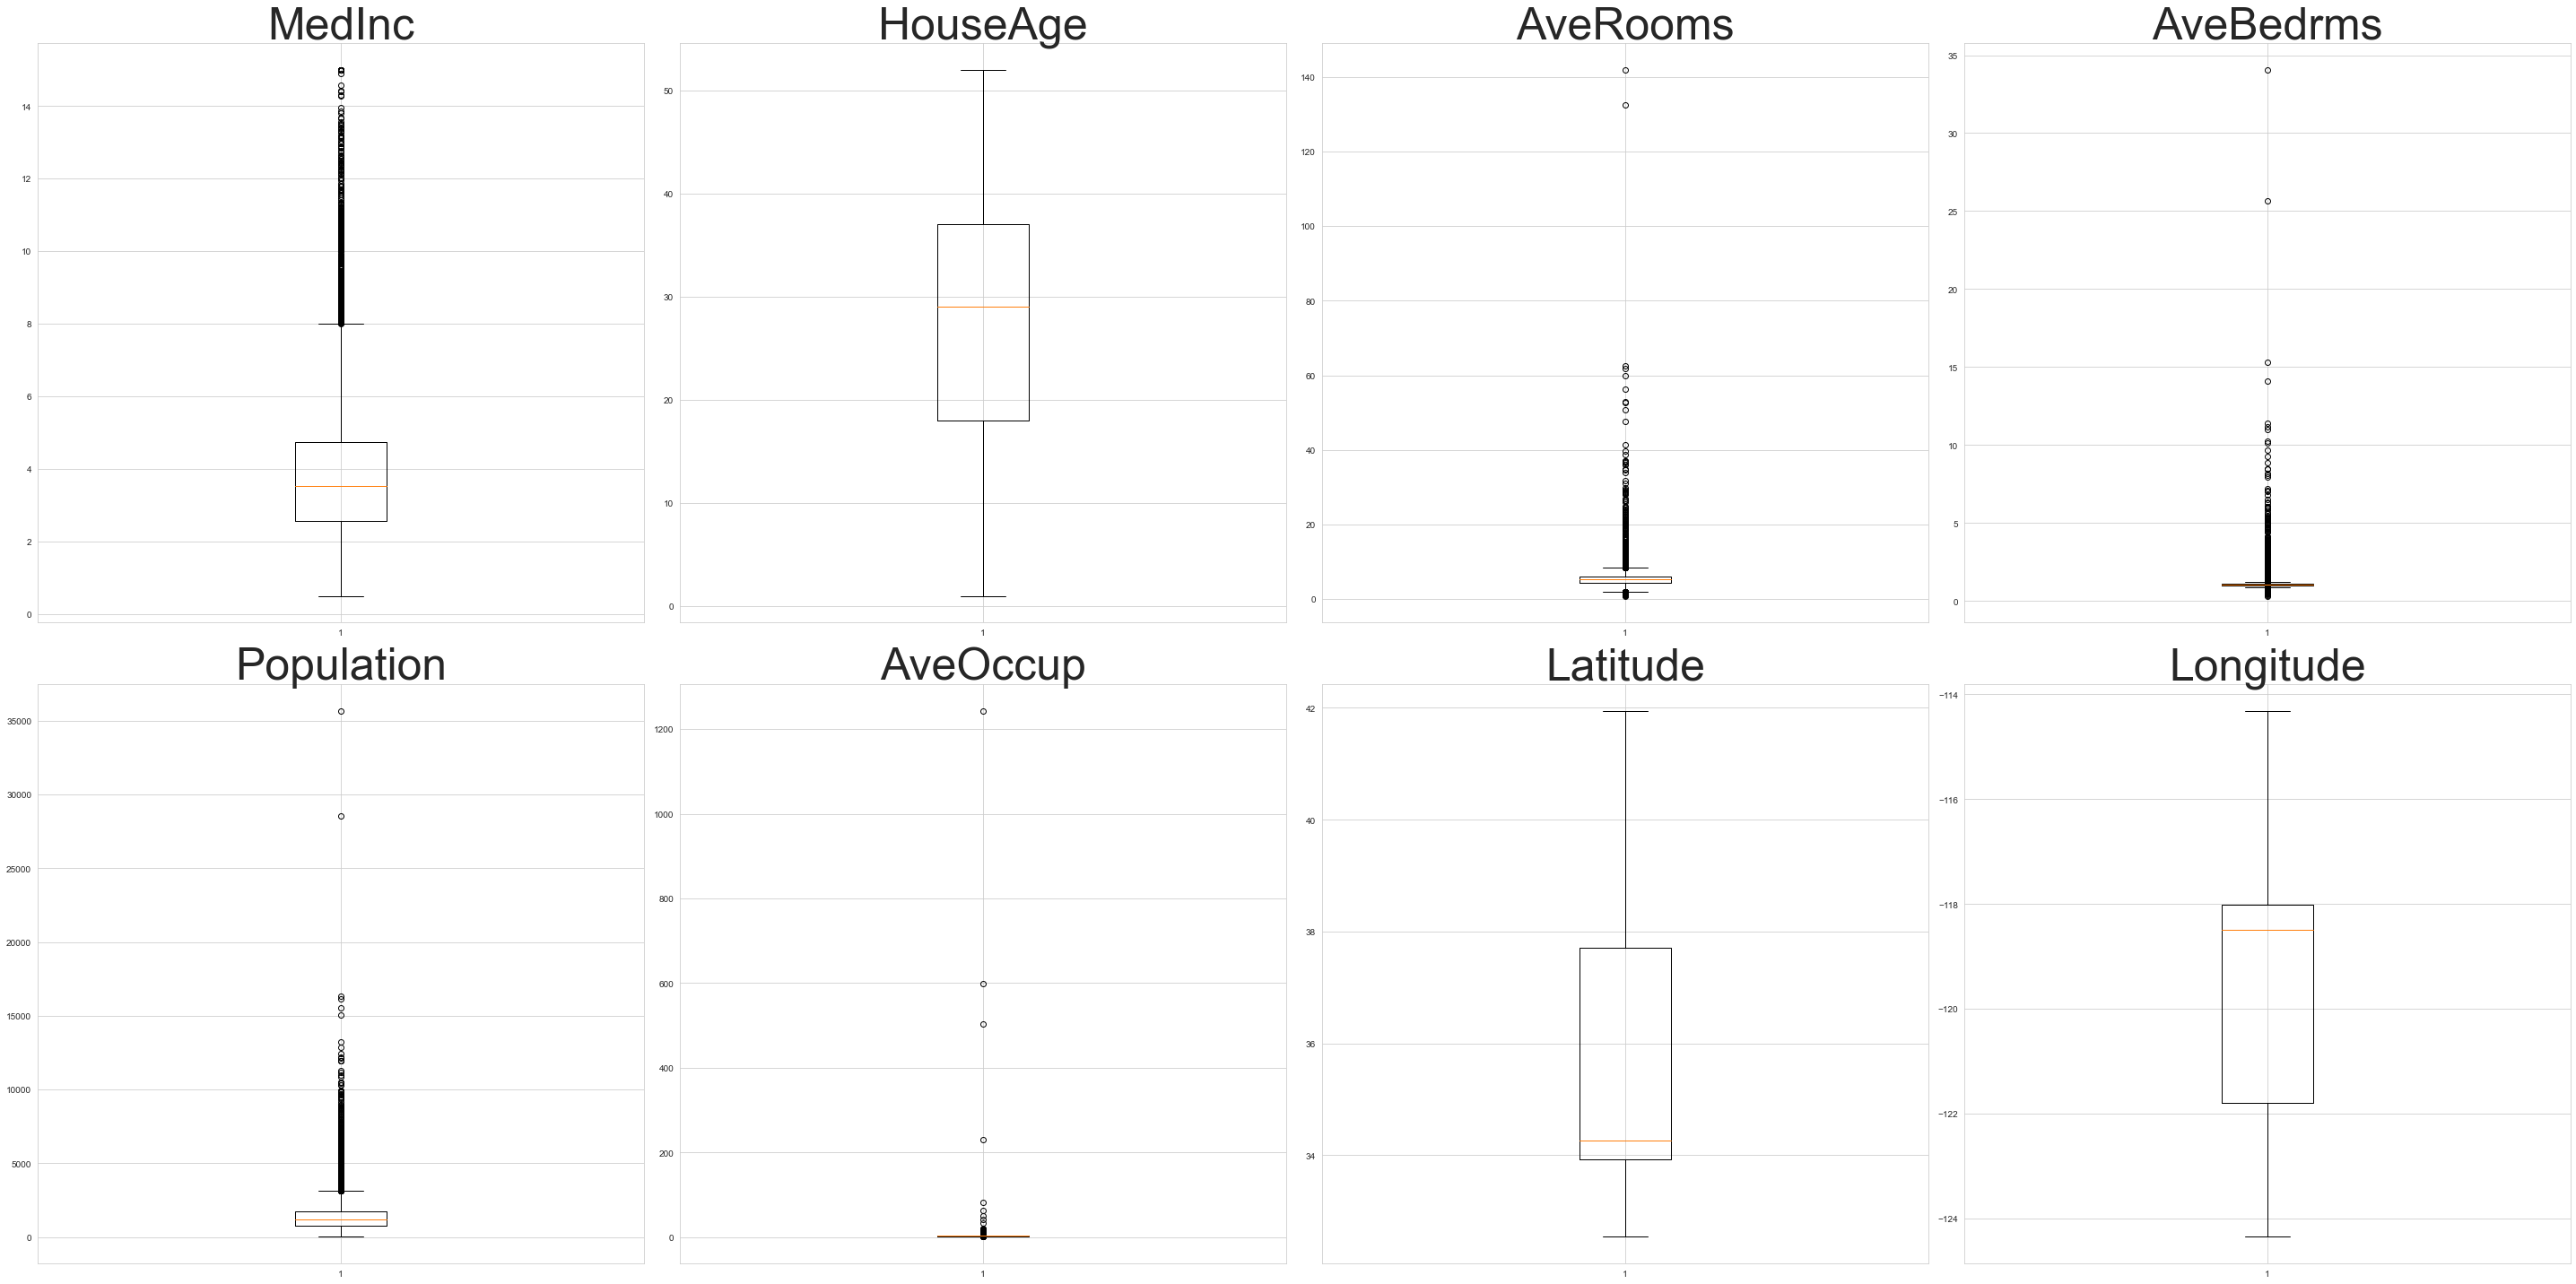

In [403]:
columns = X.columns
fig, axes = plt.subplots(2, 4, figsize=(40, 20))

# Создаем график для каждой колонки
for i, column in enumerate(columns):
    row = i // 4
    col = i % 4
    axes[row, col].boxplot(X[column])
    axes[row, col].set_title(column, size=50)

# Отображаем графики
plt.tight_layout()
plt.show()

Осуществим препроцесиинг неотфильтрованных данных и создаим пайплайн под линейную регрессию. 

In [404]:
numeric = X.columns


preprocessor = ColumnTransformer(transformers=[
    ("scaler", StandardScaler(), numeric) 
])

linear_regr_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("linear_regr", LinearRegression())
])

Разобьем неотфильтрованнае данные на тренировочные и тестовые выборки 80 на 20.

In [405]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

linear_regr_pipeline.fit(X_train, y_train)
y_test_pred = linear_regr_pipeline.predict(X_test)

Посчитаем метрики для неотфильтрованных данных.

In [406]:
# def regression_metrics(y_pred, y_true):
#     mse = np.mean(np.sum((y_pred - y_true)**2))
#     mae = np.mean(np.sum(np.abs(y_pred - y_true)))
#     r2 = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))

#     return r2, mse, mae

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score



# r2, mse, mae = regression_metrics(y_test_pred, y_test)
print(f"R^2: {r2_score(y_test, y_test_pred)}")
print(f"MSE: {mean_squared_error(y_test, y_test_pred)}")
print(f"Mae: {mean_absolute_error(y_test, y_test_pred)}")

R^2: 0.5961285884453014
MSE: 0.5405661575783067
Mae: 0.5355713790674078


Теперь приступим к фильтрации данных от выбросов. 

In [407]:
df = X.copy()
df['target'] = y

In [408]:
def remove_outliers(df, threshold=1.5):
    # Создаем копию исходного датафрейма
    filtered_df = df.copy()
    
    # Проходим по каждому столбцу в датафрейме
    for column in df.columns[0:len(df.columns)-1]:
        # Вычисляем первый и третий квартили
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        
        # Вычисляем межквартильный размах
        iqr = q3 - q1
        
        # Определяем верхнюю и нижнюю границы выбросов
        lower_bound = q1 - threshold * iqr
        upper_bound = q3 + threshold * iqr
        
        # Фильтруем значения в столбце
        filtered_df = filtered_df[(filtered_df[column] >= lower_bound) & (filtered_df[column] <= upper_bound)]
    
    return filtered_df

filtered_df = remove_outliers(df)

In [409]:
filtered_X = filtered_df.drop('target', axis=1)
filtered_y = filtered_df['target']

Отрисуем боксплоты по каждой переменной из отфильтрованных данных. 

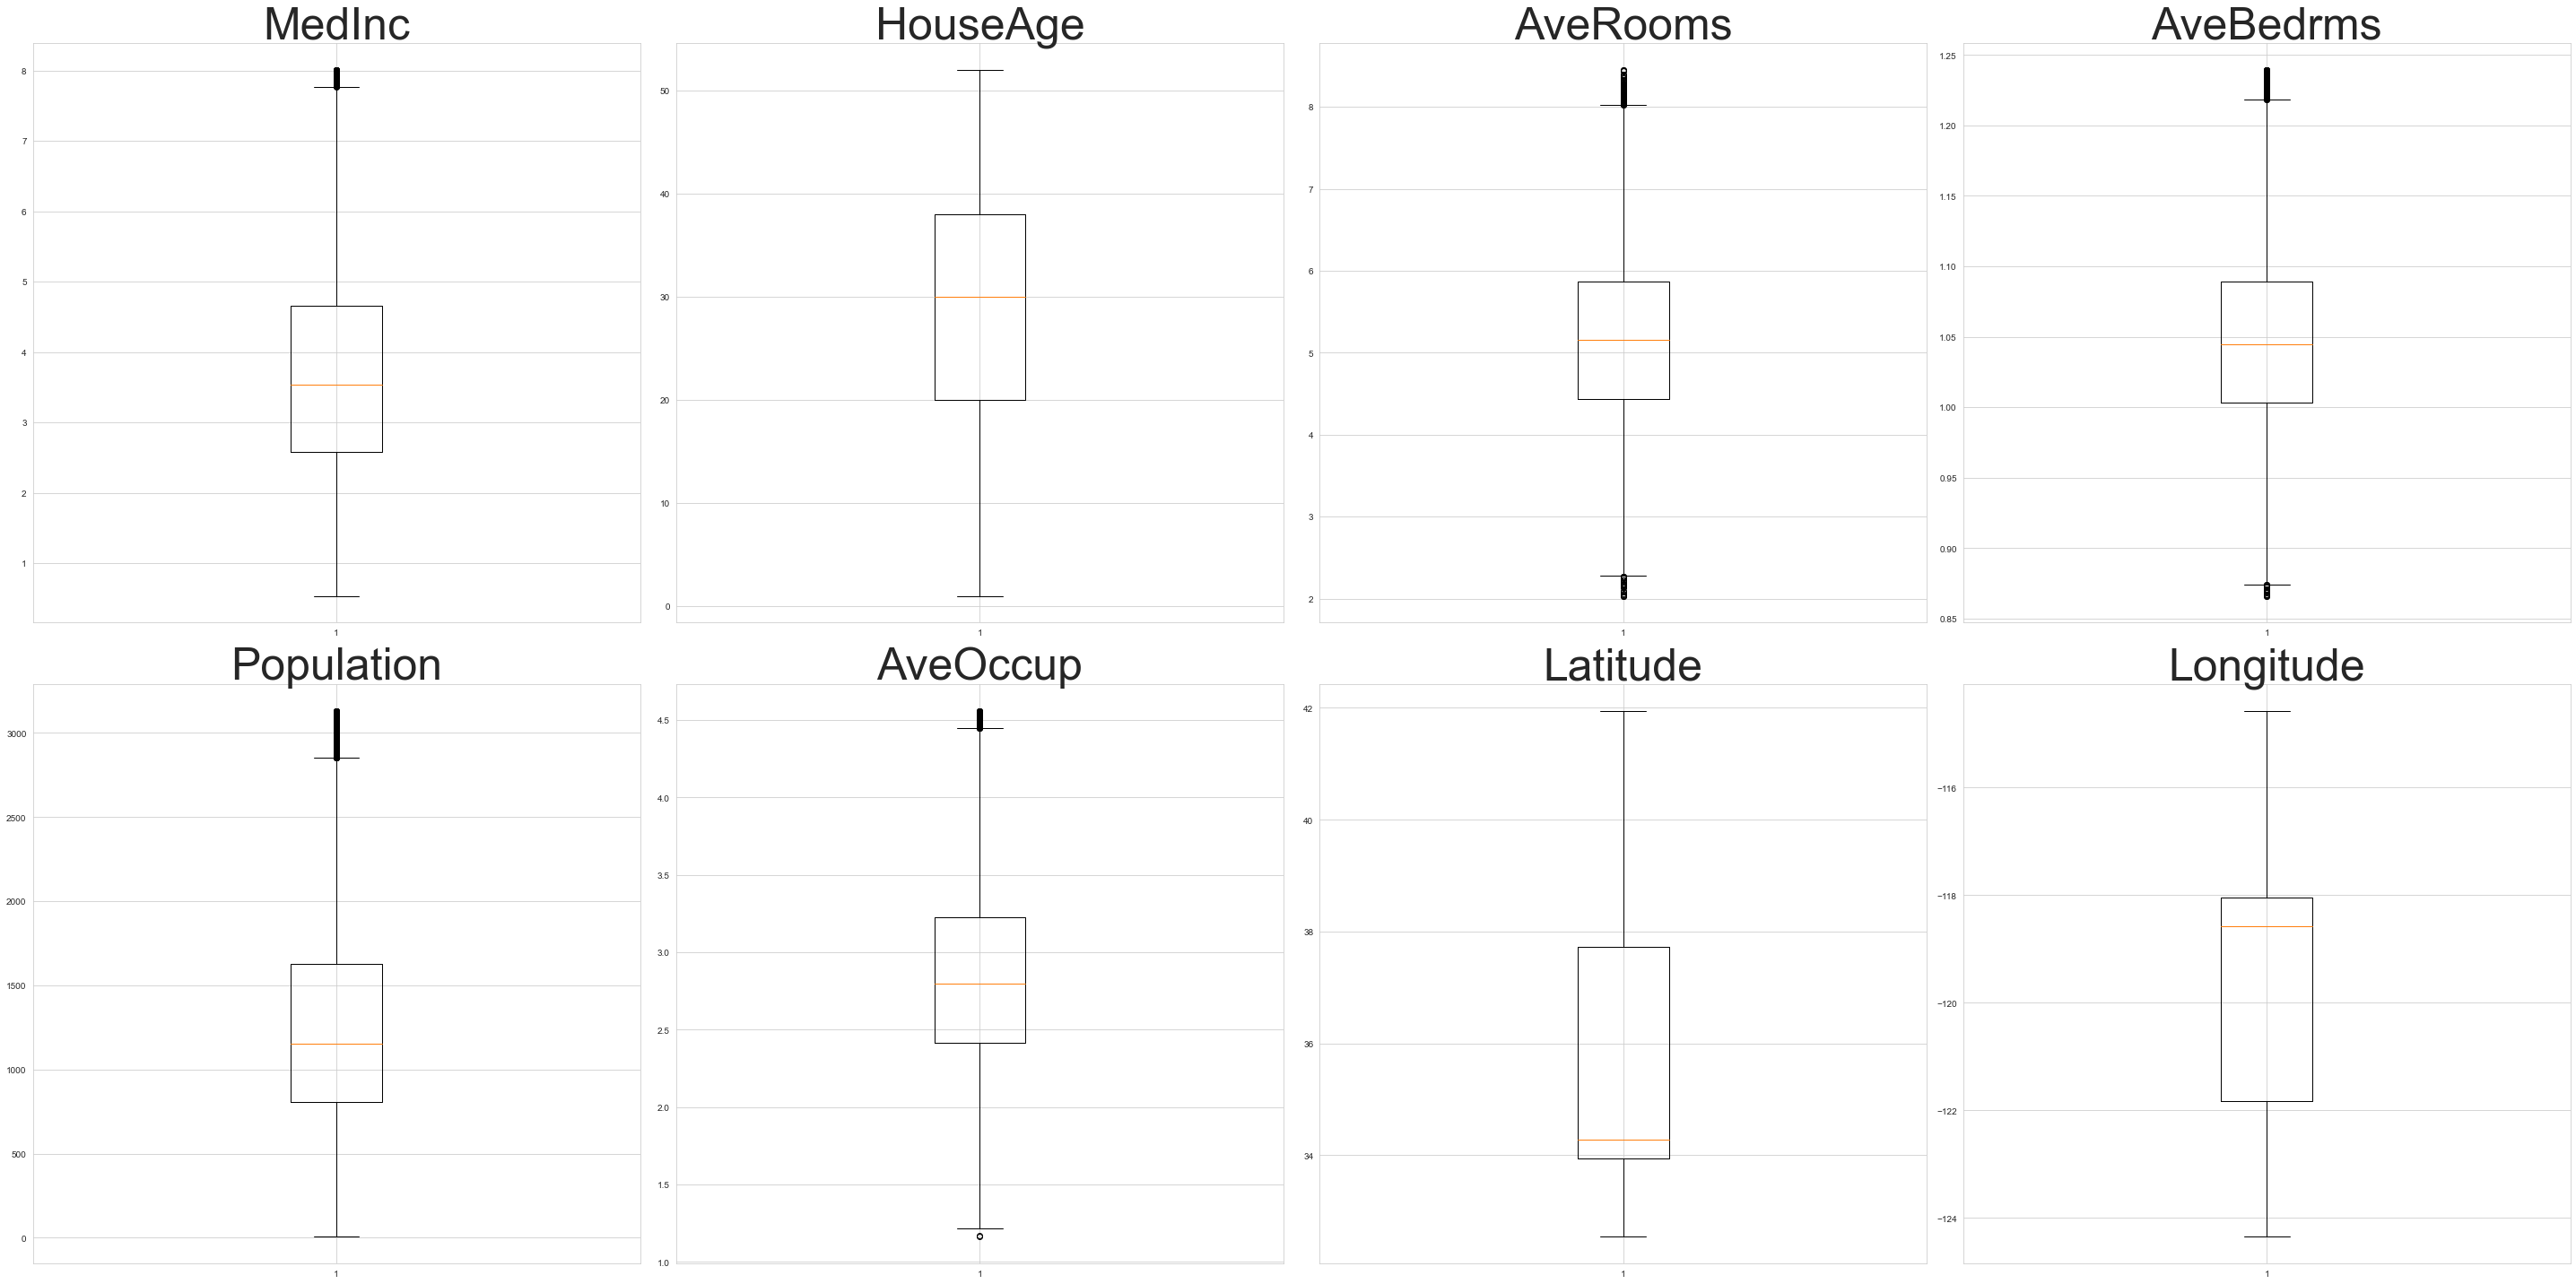

In [410]:
columns = filtered_X.columns
fig, axes = plt.subplots(2, 4, figsize=(40, 20))

# Создаем график для каждой колонки
for i, column in enumerate(columns):
    row = i // 4
    col = i % 4
    axes[row, col].boxplot(filtered_X[column])
    axes[row, col].set_title(column, size=50)

# Отображаем графики
plt.tight_layout()
plt.show()

Осуществим препроцесиинг отфильтрованных данных и создаим пайплайн под линейную регрессию.

In [411]:
from sklearn.preprocessing import StandardScaler                        
from sklearn.compose import ColumnTransformer

numeric = filtered_X.columns

preprocessor = ColumnTransformer(transformers=[
    ("scaler", StandardScaler(), numeric)
])

linear_regr_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("linear_regr", LinearRegression())
])

Разобьем отфильтрованнае данные на тренировочные и тестовые выборки 80 на 20.

In [412]:
X_train, X_test, y_train, y_test = train_test_split(filtered_X, filtered_y, test_size=0.2, random_state=SEED)

linear_regr_pipeline.fit(X_train, y_train)
y_test_pred = linear_regr_pipeline.predict(X_test)

Посчитаем метрики для отфильтрованных данных. 

In [413]:
print(f"R^2: {r2_score(y_test, y_test_pred)}")
print(f"MSE: {mean_squared_error(y_test, y_test_pred)}")
print(f"Mae: {mean_absolute_error(y_test, y_test_pred)}")

R^2: 0.6400066749097
MSE: 0.42926130208235125
Mae: 0.48922905637280945


**Вывод:**
Заметим, что в отфильтрованных данных больше $R^{2}$, а $MSE$ и $MAE$ меньше. Эти два фактв указывают на то, что модель на отфильтрованных данных предсказывает лучше. 

### Задание 3. Реализация логистической регресии (суммарно 10 баллов)

Логистическая регрессия не очень сильно отличается от обычной линейной регрессии и используется в задах классификации. Так как здесь мы снова будем пользоваться градиентным спуском, то нужно определить функцию потерь и ее градиент. Одним из самых популярных вариантов в задаче бинарной классификации является бинарная кросс-энтропия (BCE).

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Единственная проблема данной функции это возможность получить 0 под знаком логарифма, что не очень хорошо. Попробуем справить с этим "в лоб". Скажем, что наши предсказания могут принимать значения от 0 + eps до 1 - eps, где eps очень маленькое число.

#### Задание 3.1. Реализация сигмоиды (0.5 баллов)

Реализуйте функцию `sigmoid`, которая переводит действительное число $\mathbb R$ в вероятность $[0,1]$.

In [414]:
def sigmoid(output):
    # output результат X@w (-inf, +inf)
    return (1 / (1 + np.exp(-output)))

#### Задание 3.2. BCE Loss и ее градиент (2.5 балла)

Так как мы с вами только начинаем изучать машинное обучение, то было бы слишком жестоко просить вас вычислить градиент BCE Loss (он не так сложен, просто нужно привыкнуть). Поэтому сразу напишем формулу для него:

$$
\nabla{\mathcal L_{BCE}(y, \hat y), X} = X^T (\sigma({\hat{y}}) - y)
$$

In [415]:
def bce(y_true, y_pred, eps=1e-15):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    n = y_true.shape[0]
    
    # So I want escape log(0)
    y_pred = np.clip(y_pred, eps, 1 - eps)
    
    bce = -(1/n) * np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    return bce
    

def bce_grad(y_true, y_pred, X):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")

    bce_grad = np.matmul(X.T, (sigmoid(y_pred) - y_true)) 
    return bce_grad


class BCELoss:
    """
    Класс, реализующий функцию потерь BCE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return bce(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return bce_grad(y_true, y_pred, X)

#### Задание 3.3. Предсказания логистической регрессии (2 балла)

Реализуйте метод `predict` у класса `CustomLogisticRegression`, не забудьте про свободный член!

In [416]:
class CustomLogisticRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-3,
                 loss_function=BCELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        super().__init__(learning_rate=learning_rate,
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
    
    
    def predict(self, X_test):
        if self.W is None:
            raise NotFittedError("This CustomLogisticRegression instance is not fitted, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            
        linear_output = np.dot(X_test, self.W)  
        probabilities = sigmoid(linear_output)
        predicted_labels = np.where(probabilities >= 0.5, 1, 0)

        return predicted_labels
    
    
    def __repr__(self):
        return "My custom logistic regression"

#### Снова проверим работу алгоритма на простом примере

In [417]:
# Создадим датасет из 1 признака и 2 классов
X, y = make_classification(n_features=1, n_informative=1,
                           n_redundant=0, n_clusters_per_class=1)

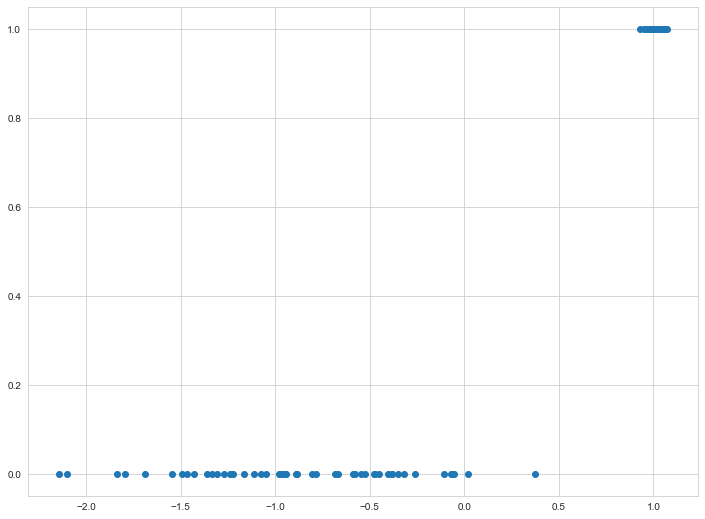

In [418]:
plt.scatter(X, y);

In [419]:
custom_log_reg = CustomLogisticRegression()
custom_log_reg.fit(X, y)
y_pred = custom_log_reg.predict(X)

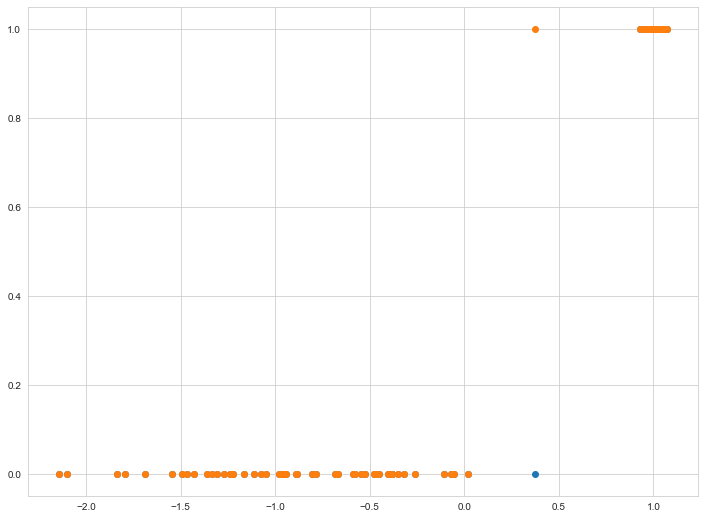

In [429]:
plt.scatter(X, y)
plt.scatter(X, y_pred)

Проверьте качество работы модели при помощи известных вам метрик бинарной классификации.

In [304]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
print(f'Percision: {round(precision_score(y, y_pred), 3)}')
print(f'Recall: {recall_score(y, y_pred)}')
print(f'F1: {round(f1_score(y, y_pred), 3)}')
print(f'Accuracy: {accuracy_score(y, y_pred)}')

Percision: 0.98
Recall: 1.0
F1: 0.99
Accuracy: 0.99


#### Задание 3.4. Применение логистической регрессии (5 баллов)

Мы будем использовать данные по свойствам покемонов (https://www.kaggle.com/abcsds/pokemon). В данном задании вам необходимо сначала сделать краткий EDA (Посмотреть на данные и их распределения, а также посмотреть, как различные признаки связаны между собой и с целевой переменной (`Legendary`)).

In [305]:
pokemon = pd.read_csv("Pokemon.csv")
pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [306]:
pokemon.info()
print(f'\nNumber of variables: {pokemon.shape[1]}')
print(f'Number of observations: {pokemon.shape[0]}')
print(f'NA in dataset: {sum(pokemon.isna().sum())}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB

Number of variables: 13
Number of observations: 800
NA in dataset: 386


In [307]:
pokemon.isna().sum()

#               0
Name            0
Type 1          0
Type 2        386
Total           0
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64

In [308]:
pokemon.nunique()

#             721
Name          800
Type 1         18
Type 2         18
Total         200
HP             94
Attack        111
Defense       103
Sp. Atk       105
Sp. Def        92
Speed         108
Generation      6
Legendary       2
dtype: int64

In [309]:
pokemon['Type 1'].unique()

array(['Grass', 'Fire', 'Water', 'Bug', 'Normal', 'Poison', 'Electric',
       'Ground', 'Fairy', 'Fighting', 'Psychic', 'Rock', 'Ghost', 'Ice',
       'Dragon', 'Dark', 'Steel', 'Flying'], dtype=object)

In [310]:
pokemon['Type 2'].unique()

array(['Poison', nan, 'Flying', 'Dragon', 'Ground', 'Fairy', 'Grass',
       'Fighting', 'Psychic', 'Steel', 'Ice', 'Rock', 'Dark', 'Water',
       'Electric', 'Fire', 'Ghost', 'Bug', 'Normal'], dtype=object)

In [311]:
pokemon = pokemon.fillna('No second type')

In [312]:
pokemon = pokemon.rename(columns={'Type 1':'Type_1', 'Type 2':'Type_2'})

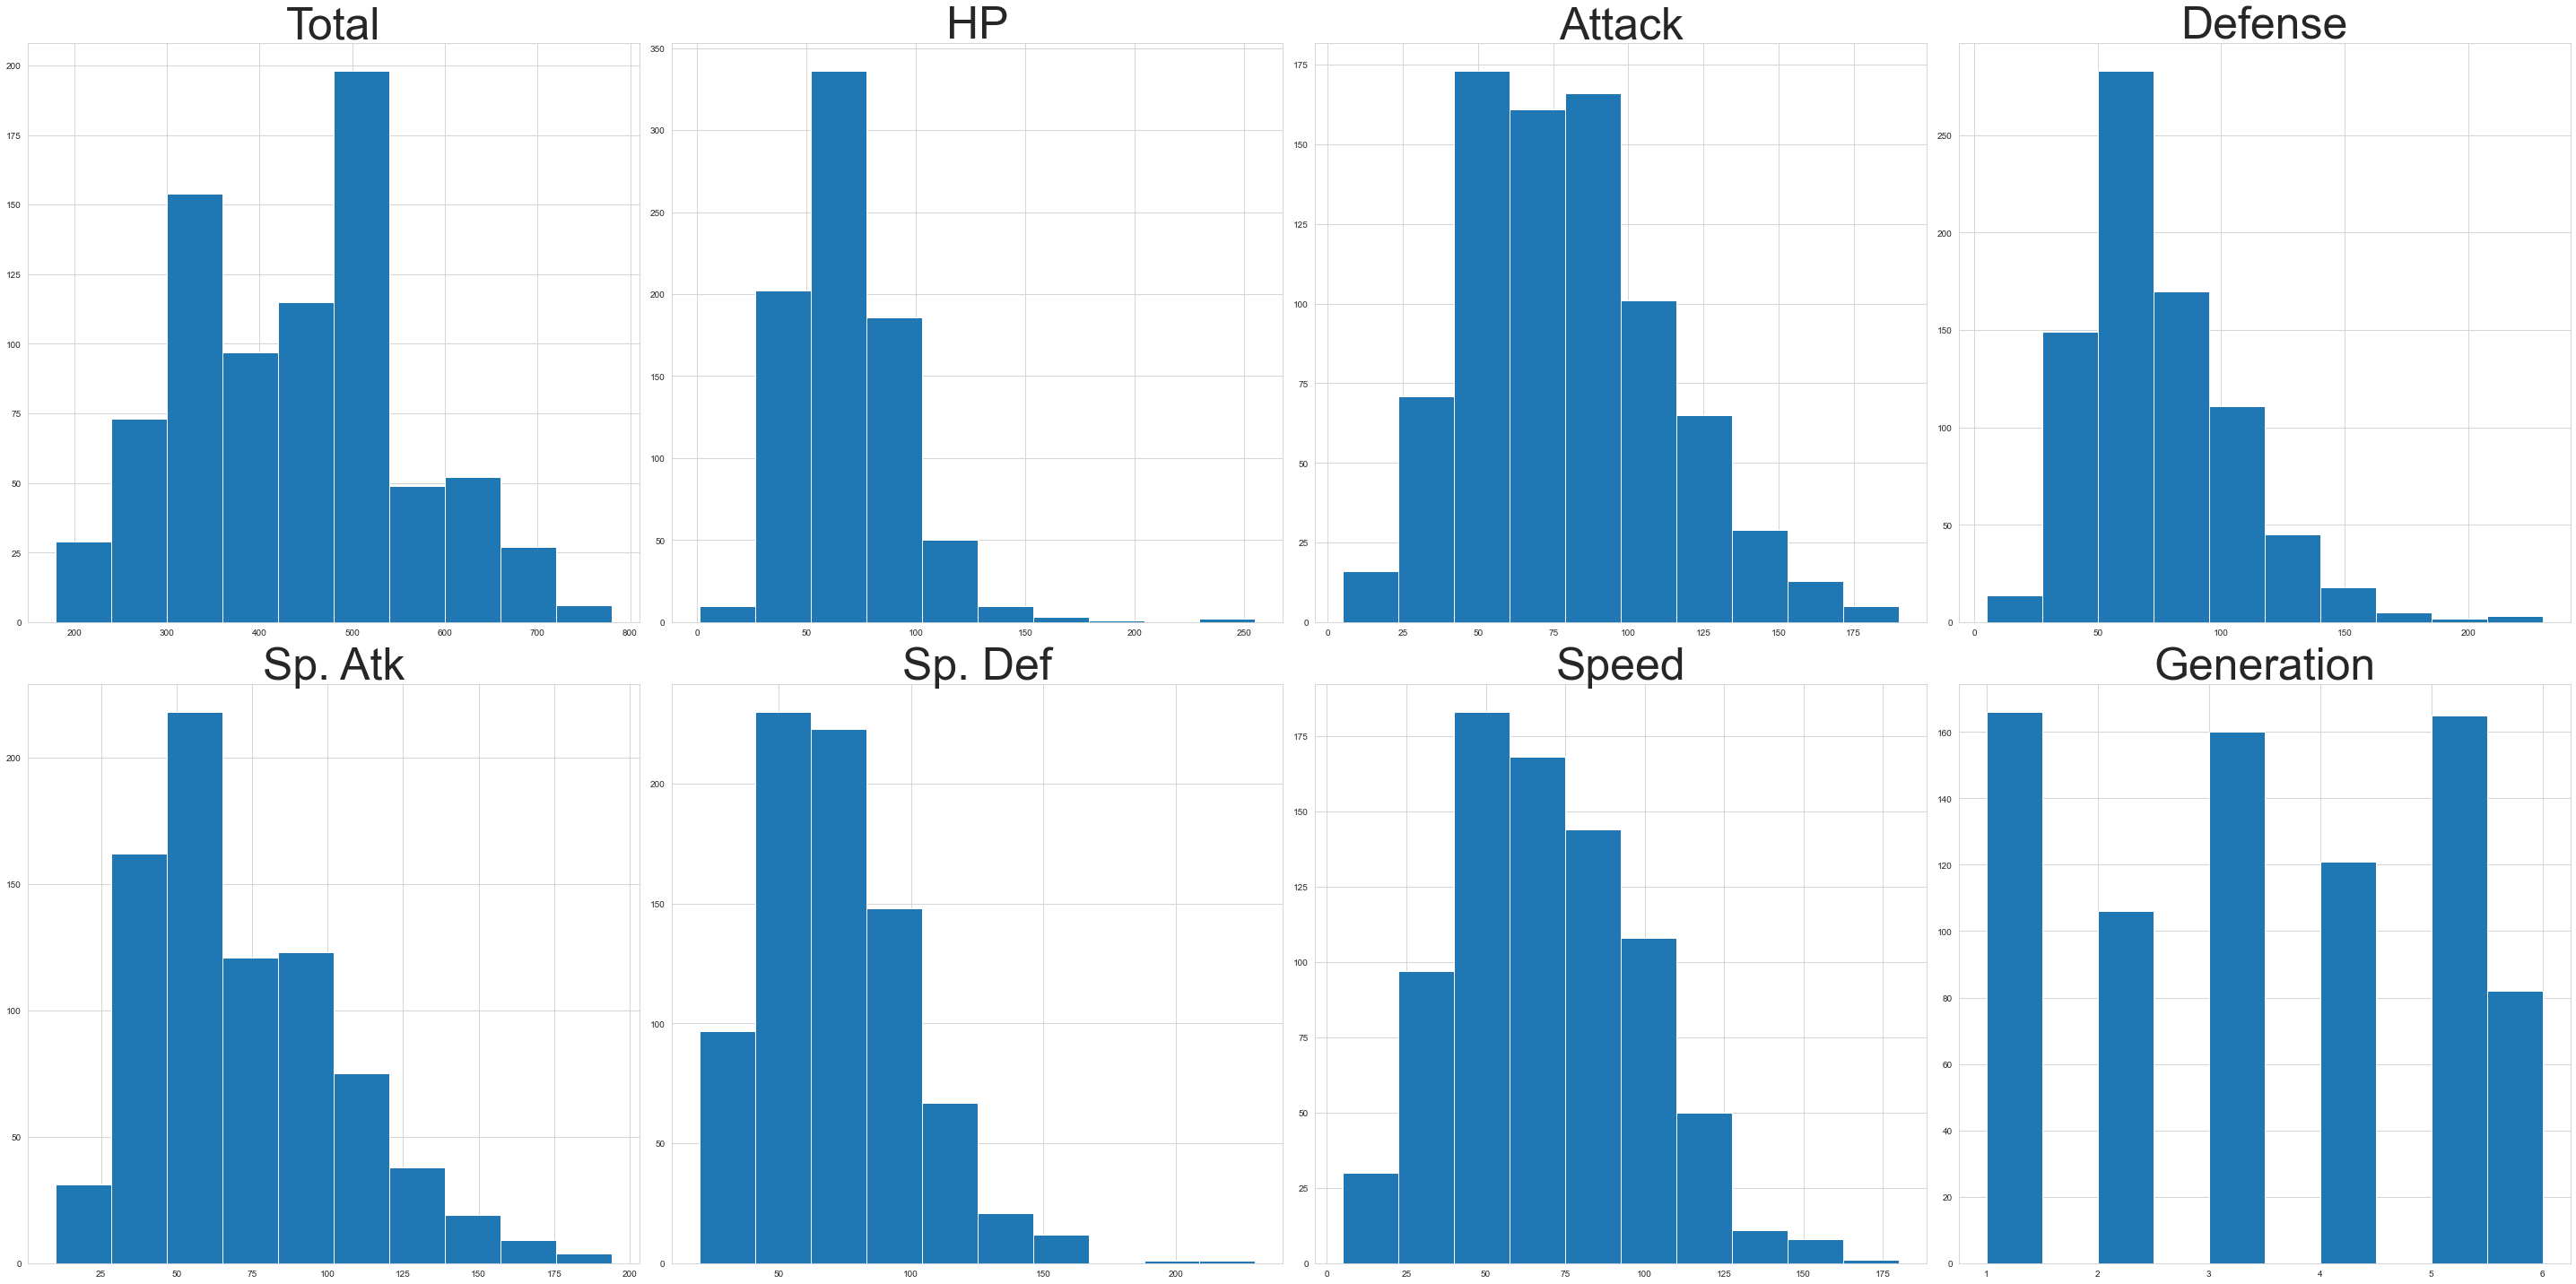

In [313]:
sorted_columns_pokemon = pokemon.drop(['Name', 'Legendary', '#', 'Type_1', 'Type_2'], axis=1)
columns = sorted_columns_pokemon.columns

fig, axes = plt.subplots(2, 4, figsize=(40, 20))

# Создаем график для каждой колонки
for i, column in enumerate(columns):
    row = i // 4
    col = i % 4
    axes[row, col].hist(sorted_columns_pokemon[column])
    axes[row, col].set_title(column, size=50)

# Отображаем графики
plt.tight_layout()
plt.show()



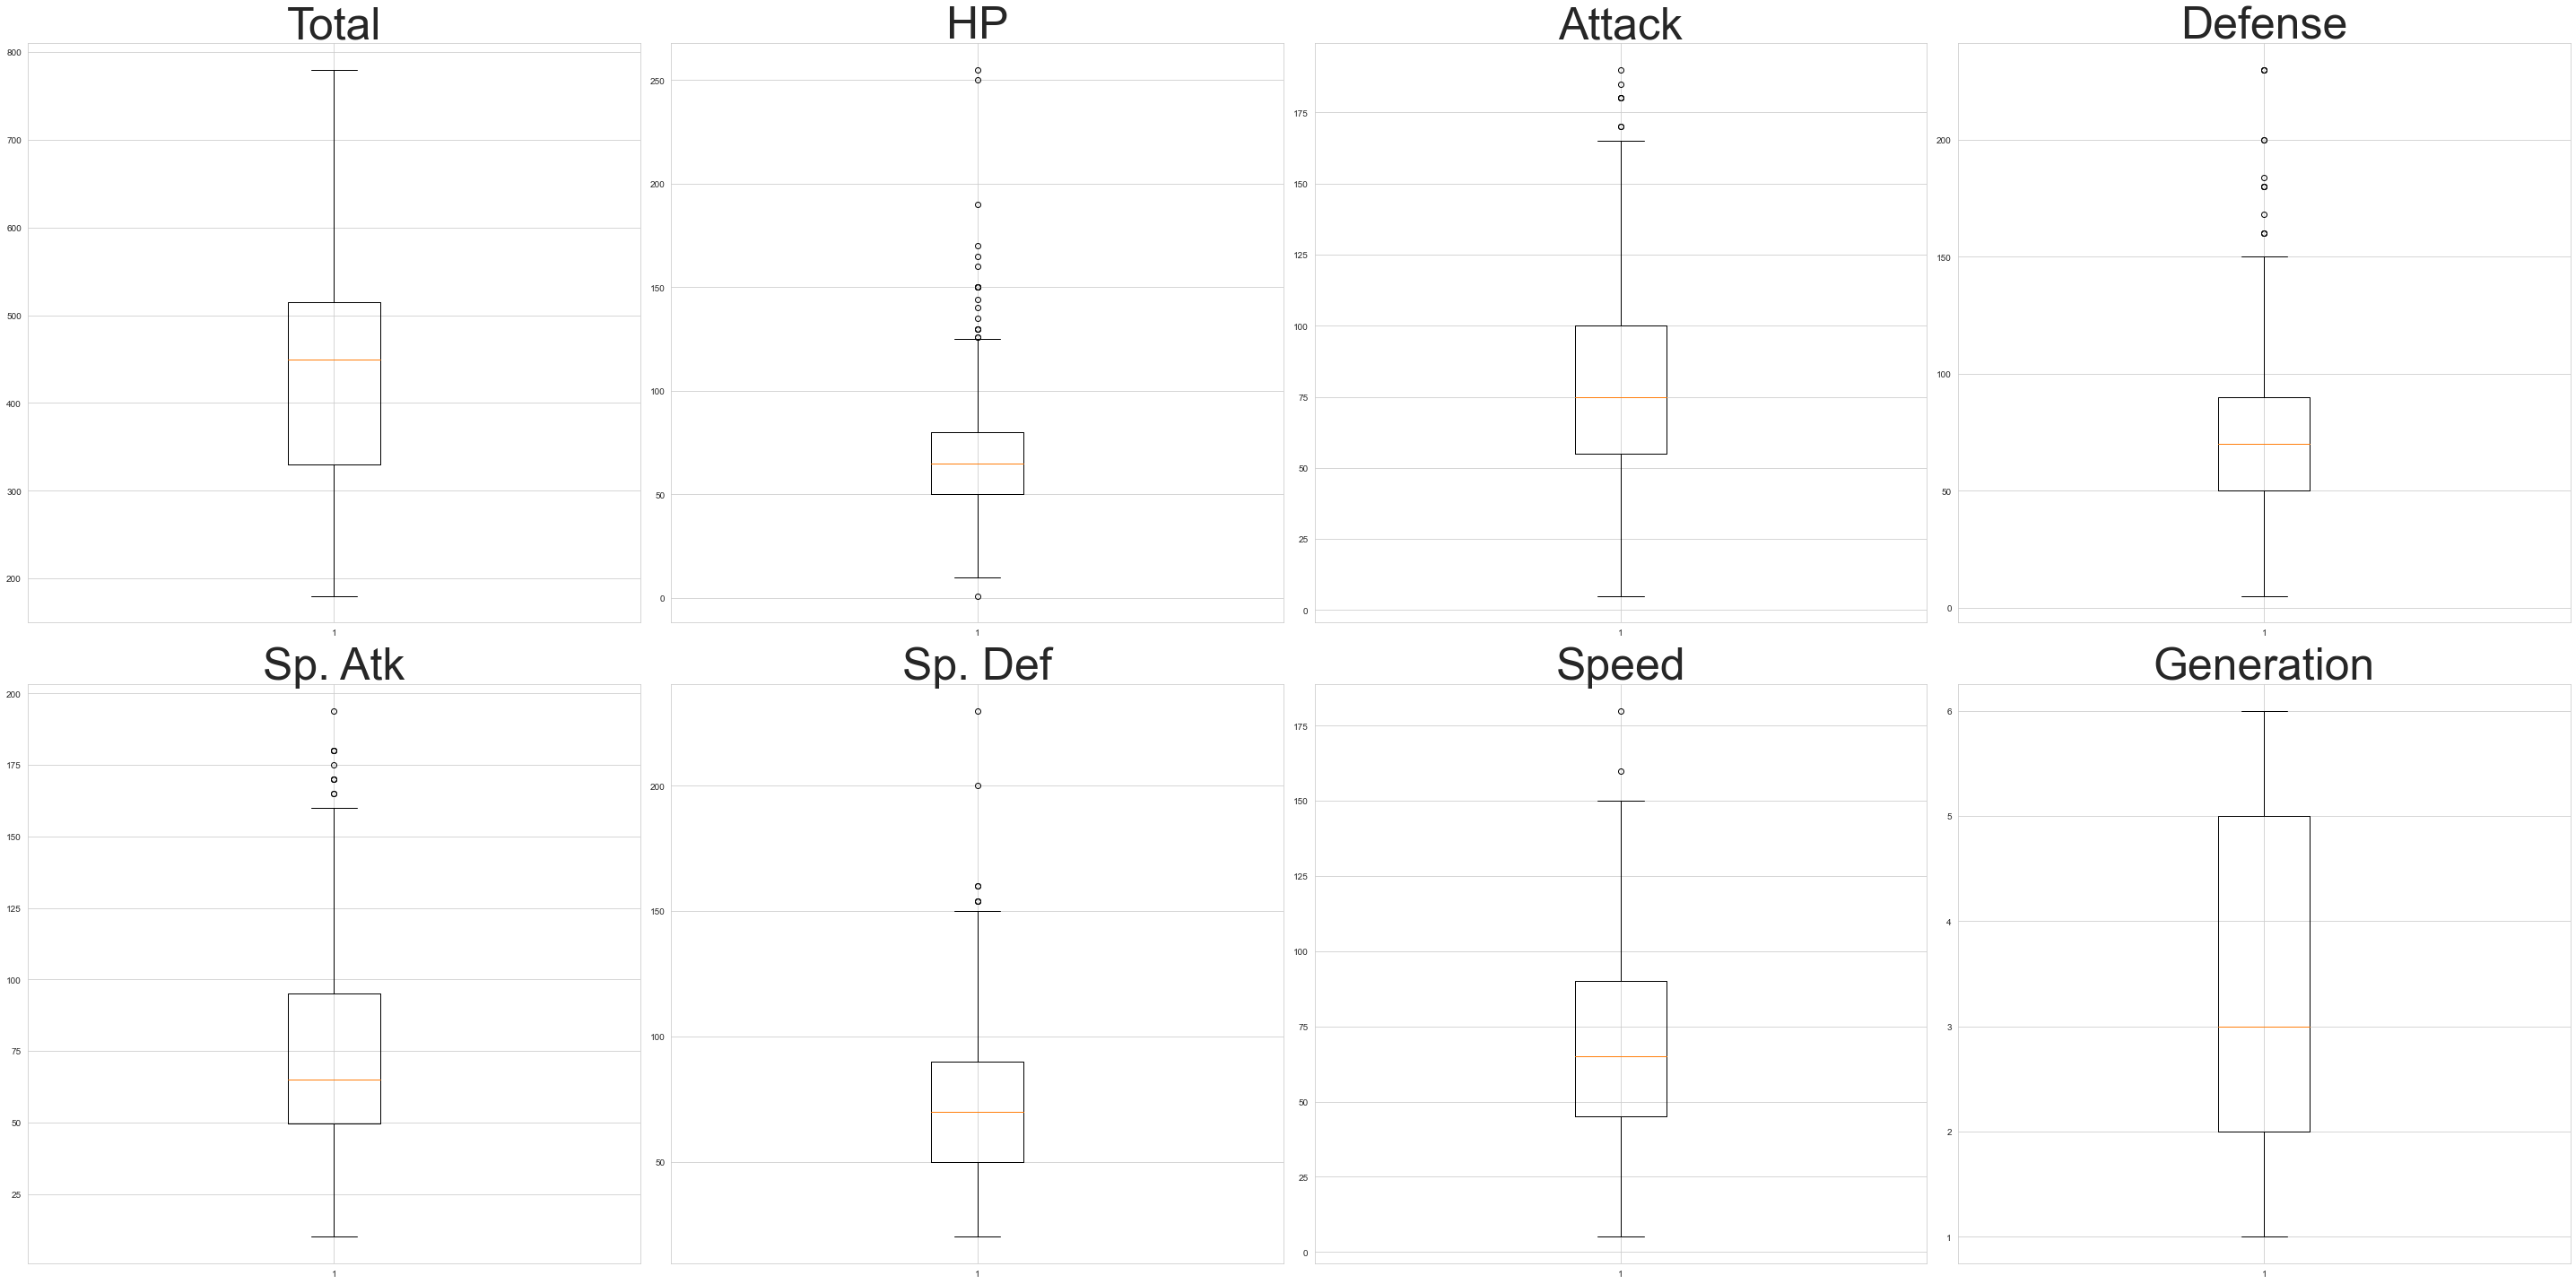

In [314]:
fig, axes = plt.subplots(2, 4, figsize=(40, 20))

# Создаем график для каждой колонки
for i, column in enumerate(columns):
    row = i // 4
    col = i % 4
    axes[row, col].boxplot(sorted_columns_pokemon[column])
    axes[row, col].set_title(column, size=50)

# Отображаем графики
plt.tight_layout()
plt.show()


In [315]:
sorted_columns_pokemon.corr()


,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
Total,1.000000,0.618748,0.736211,0.612787,0.747250,0.717609,0.575943,0.048384
HP,0.618748,1.000000,0.422386,0.239622,0.362380,0.378718,0.175952,0.058683
Attack,0.736211,0.422386,1.000000,0.438687,0.396362,0.263990,0.381240,0.051451
Defense,0.612787,0.239622,0.438687,1.000000,0.223549,0.510747,0.015227,0.042419
Sp. Atk,0.747250,0.362380,0.396362,0.223549,1.000000,0.506121,0.473018,0.036437
Sp. Def,0.717609,0.378718,0.263990,0.510747,0.506121,1.000000,0.259133,0.028486
Speed,0.575943,0.175952,0.381240,0.015227,0.473018,0.259133,1.000000,-0.023121
Generation,0.048384,0.058683,0.051451,0.042419,0.036437,0.028486,-0.023121,1.000000


Из матрицы корреляции можем установить зависимость *Total* от всех предикторов, кроме *Generation*.

In [316]:
pokemon.corr()

,#,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
#,1.000000,0.119813,0.097614,0.102298,0.094786,0.088759,0.085817,0.010733,0.982516,0.153396
Total,0.119813,1.000000,0.618748,0.736211,0.612787,0.747250,0.717609,0.575943,0.048384,0.501758
HP,0.097614,0.618748,1.000000,0.422386,0.239622,0.362380,0.378718,0.175952,0.058683,0.273620
Attack,0.102298,0.736211,0.422386,1.000000,0.438687,0.396362,0.263990,0.381240,0.051451,0.345408
Defense,0.094786,0.612787,0.239622,0.438687,1.000000,0.223549,0.510747,0.015227,0.042419,0.246377
Sp. Atk,0.088759,0.747250,0.362380,0.396362,0.223549,1.000000,0.506121,0.473018,0.036437,0.448907
Sp. Def,0.085817,0.717609,0.378718,0.263990,0.510747,0.506121,1.000000,0.259133,0.028486,0.363937
Speed,0.010733,0.575943,0.175952,0.381240,0.015227,0.473018,0.259133,1.000000,-0.023121,0.326715
Generation,0.982516,0.048384,0.058683,0.051451,0.042419,0.036437,0.028486,-0.023121,1.000000,0.079794
Legendary,0.153396,0.501758,0.273620,0.345408,0.246377,0.448907,0.363937,0.326715,0.079794,1.000000


Переменная *Legendary* коррелирует с *Total*

Мы будем предсказывать является ли покемон легендарным или нет. Замените логическое значение колонки на числовое (перекодировав на 0 и 1). Также подумайте, как в этом случае лучше закодировать категориальные признаки (может быть, лучше их просто выбросить?).

In [317]:
pokemon['Legendary'] = pokemon['Legendary'].replace({False: 0, True: 1})

In [319]:
pokemon = pokemon.drop(['#', 'Name', 'Type_1', 'Type_2'], axis=1)

In [320]:
num_cols = pokemon.columns[0:len(pokemon.columns)-2]
cat_cols = ['Generation']

In [322]:
preprocessor = ColumnTransformer(transformers=[
    ("scaler", StandardScaler(), num_cols),
    ("ohe", OneHotEncoder(drop="first"), cat_cols)
])

In [331]:
log_regr_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("log_regr", LogisticRegression())
])

Разделите ваши данные на тестовую и тренировочную выборку.

In [326]:
pokemon_X, pokemon_y = pokemon.drop('Legendary', axis=1), pokemon['Legendary']

In [327]:
X_train, X_test, y_train, y_test = train_test_split(pokemon_X, pokemon_y, test_size=0.2, random_state=SEED)

Обучите модель `LogisticRegression` из `sklearn`.

In [334]:
log_regr_pipeline.fit(X_train, y_train)
y_test_pred = log_regr_pipeline.predict(X_test)
y_test_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [355]:
X_train.shape, y_train.shape, X_test.shape, y_test_pred.shape

((640, 8), (640,), (160, 8), (160,))

Выведите метрики вашего классификатора:

1. Нарисуйте [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html).

2. Изобразите ROC кривую и посчитайте площадь под ней.

3. Скажите, какие признаки оказались наиболее важны для модели.

Normalized confusion matrix


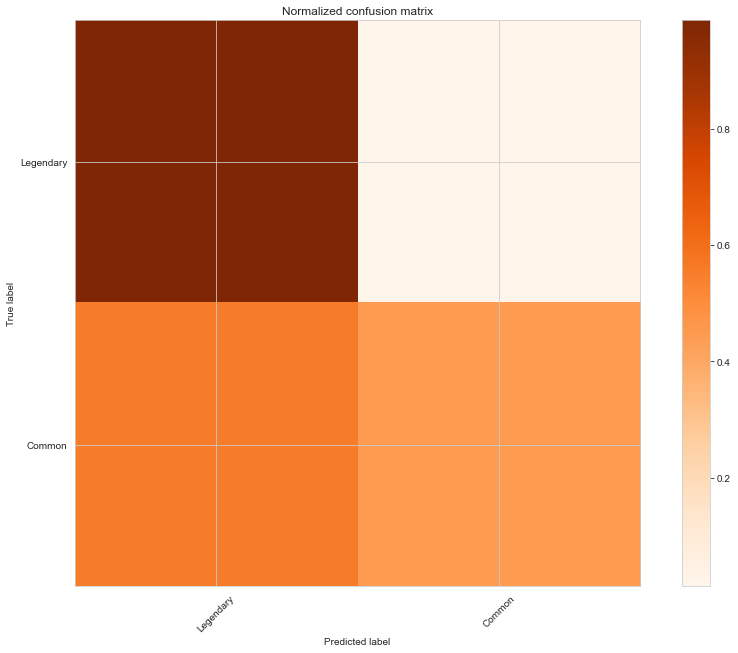

In [377]:
from sklearn.metrics import confusion_matrix

# Пример истинных меток и прогнозируемых меток
y_true = y_test
y_pred = y_test_pred

# Создаем матрицу ошибок
cm = confusion_matrix(y_true, y_pred)

# Функция для отображения матрицы ошибок в виде графика
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Oranges):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Определяем список классов
class_names = ['Legendary', 'Common']

# Создаем график матрицы ошибок
plt.figure()
plot_confusion_matrix(cm, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

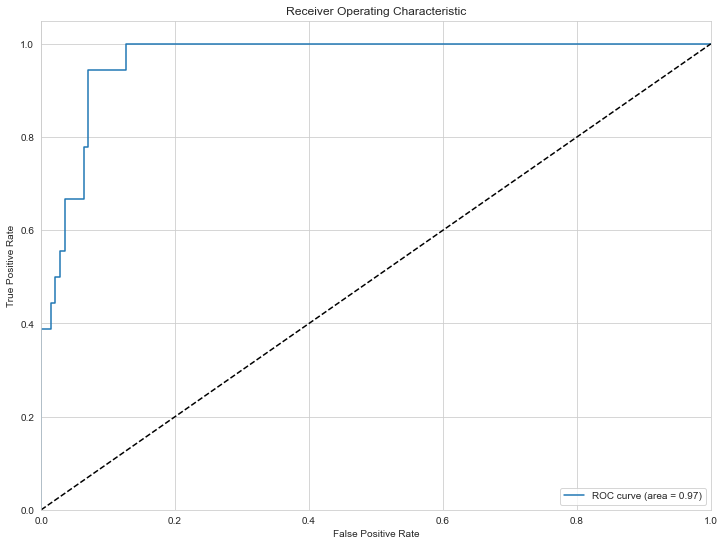

In [378]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

y_pred_prob = log_regr_pipeline.predict_proba(X_test)[:, 1]

# Вычисление значений FPR и TPR для ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Вычисление значения AUC-ROC
auc = roc_auc_score(y_test, y_pred_prob)

# Построение ROC-кривой
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')  # Диагональная линия
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Полученные метрики подтверждают то, что наша модель хорошо разделят классы. 

Наиболее важной переменной стала *Total*, так как она зависела от еще нескольких переменных и это повлияло на предсказательную силу модели и на устойчивость модели к изменениям.

### Задание 4. Расскажите о вашей любимой музыкальной группе (исполнителе) (0.5 балла)

Расскажите, как вы познакомились с этой группой и скиньте несколько наиболее любимых треков)

Я тут думал и хотел рассказать, что у меня нет любимой группы, я меломан, слушая по настроению и прочее из этой оперы, но вспомнил, есть две группы, которые я очень много слушал, правда, на разных этапах. Начну с Рамштайна, слушал их в своем 11 классе и на первом курсе, для меня в то время символичной стала песня *Moskau*. А вторая группа, думаю, как и у многих с нашего потока, КИШ. Я их слушал и слышал давно, но очевидно, что определенную лепту внес и сериал, потом я уже сам стал знакомиться с их творчетсвом ближею

А что касаемо исполнителей, тот мне очень сильно нравится творчество Кендрика Ламара и Викенда, альбом последнего "Starboy" в последнее время кучу раз переслушивал.

## Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз. 

**Ваши мысли:**

Эта домашка далась полегче, чем предыдущая. 